# 2023 Immune H3K27ac extra

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import tempfile

In [2]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file

def d(a, b):
    return a / b if b != 0 else 0

def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

## Load peaks

In [3]:
PATH = os.path.expanduser('~/data/2023_Immune')
# PATH = os.path.expanduser('~/data/2023_Immune_no_control')
IMMUNE_CELLS = ['BCell', 'TCell']
MODIFICATIONS = ['H3K27ac']

! mkdir -p {PATH}/pics

In [51]:
def load_peaks_fdr(path, suffix, fdrs):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'cell', 'fdr', 'peaks', 'avlength'],
                          dtype=object)
    for f in tqdm(os.listdir(path)):
        if suffix not in f:
            continue
        fdr = next((fdr for fdr in fdrs if fdr in f), None)
        cell = next((cc for cc in IMMUNE_CELLS if cc in f), None)
        mod = next((m for m in MODIFICATIONS if m in f), None)
        # print(f, fdr, cell, mod)
        if fdr and cell and mod:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            avls = 0 if ps == 0 else sum(ls) / ps
            df_fdr.loc[len(df_fdr)] = (peaks_path, mod, cell, fdr, ps, avls)
    return df_fdr


In [52]:
df_fdr_macs2 = load_peaks_fdr(os.path.join(PATH, 'macs2'), '.narrowPeak', ['0.05'])
df_fdr_macs2['tool'] = 'MACS2'
print('MACS2', len(df_fdr_macs2))

df_fdr_macs2broad = load_peaks_fdr(os.path.join(PATH, 'macs2'), '.broadPeak', ['0.1'])
df_fdr_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_fdr_macs2broad))

df_fdr_sicer = load_peaks_fdr(os.path.join(PATH, 'sicer'), 'summary-FDR', ['0.01'])
# df_fdr_sicer = load_peaks_fdr(os.path.join(PATH, 'sicer'), 'scoreisland', ['0.01'])
df_fdr_sicer['tool'] = 'SICER'
print('SICER', len(df_fdr_sicer))

df_fdr_span = load_peaks_fdr(os.path.join(PATH, 'span'), '.peak', ['0.05'])
df_fdr_span['tool'] = 'SPAN'
print('SPAN', len(df_fdr_span))

TOOLS = ['MACS2', 'MACS2 broad', 'SICER', 'SPAN']
df_fdr_peaks = pd.concat([df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer, df_fdr_span])
df_fdr_peaks.sample(5)

  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 2


  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 broad 2


  0%|          | 0/118 [00:00<?, ?it/s]

SICER 2


  0%|          | 0/17 [00:00<?, ?it/s]

SPAN 2


,file,modification,cell,fdr,peaks,avlength,tool
0,/home/jetbrains/data/2023_Immune/span/TCell_H3...,H3K27ac,TCell,0.05,31192,2721.691267,SPAN
1,/home/jetbrains/data/2023_Immune/sicer/BCell_H...,H3K27ac,BCell,0.01,24342,3746.687125,SICER
0,/home/jetbrains/data/2023_Immune/sicer/TCell_H...,H3K27ac,TCell,0.01,26338,4713.686005,SICER
1,/home/jetbrains/data/2023_Immune/macs2/BCell_H...,H3K27ac,BCell,0.05,45626,877.539539,MACS2
0,/home/jetbrains/data/2023_Immune/macs2/TCell_H...,H3K27ac,TCell,0.05,57350,960.794316,MACS2


In [53]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER', 'DNAse']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

# Update peaks to contain only percentile only

In [54]:
# df_fdr_peaks.drop(['avlength'], axis=1, inplace=True)
df_fdr_peaks['original_file'] = df_fdr_peaks['file']

step = 20
for percentage in [0, 20, 40, 60, 80]:
    percentage_name = f'{percentage}%-{percentage + step}%'
    ! mkdir -p {PATH}/percentiles/{percentage_name}
    print(percentage_name)
    percentile_files = []
    for file, cell in tqdm(zip(df_fdr_peaks['file'], df_fdr_peaks['cell'])):
        pf = f'{PATH}/percentiles/{percentage_name}_H3K27ac_{cell}.bed'
        union_path = f'{PATH}/union/H3K27ac_{cell}.bed'
        t = pd.read_csv(union_path, sep='\t', header=None, usecols=[0, 1, 2])
        t[3] = t[2] - t[1]
        t.sort_values(by=[3, 0, 1, 2], inplace=True)

        # Take % peaks by lengths and compute ratios inside
        t.iloc[int(len(t) * percentage / 100):int(len(t) * (percentage + step) / 100)][[0, 1, 2]].to_csv(
            pf, sep='\t', index=False, header=None
        )
        # Prepare percentage
        file_perc = f'{PATH}/percentiles/{percentage_name}/{os.path.basename(file)}'
        print(percentage_name, cell, file_perc)
        ! bedtools intersect -wa -u -a {sorted_file(file)} -b {sorted_file(pf)} > {file_perc}
        percentile_files.append(file_perc)
    df_fdr_peaks[percentage_name] = percentile_files

df_fdr_peaks.sample(5)

0%-20%


0it [00:00, ?it/s]

0%-20% TCell /home/jetbrains/data/2023_Immune/percentiles/0%-20%/TCell_H3K27ac_hg38_ENCFF530DQB_q0.05_peaks.narrowPeak
0%-20% BCell /home/jetbrains/data/2023_Immune/percentiles/0%-20%/BCell_H3K27ac_hg38_ENCFF404HKA_q0.05_peaks.narrowPeak
0%-20% TCell /home/jetbrains/data/2023_Immune/percentiles/0%-20%/TCell_H3K27ac_hg38_ENCFF530DQB_broad0.1_peaks.broadPeak
0%-20% BCell /home/jetbrains/data/2023_Immune/percentiles/0%-20%/BCell_H3K27ac_hg38_ENCFF404HKA_broad0.1_peaks.broadPeak
0%-20% TCell /home/jetbrains/data/2023_Immune/percentiles/0%-20%/TCell_H3K27ac_hg38_ENCFF530DQB-W200-G600-islands-summary-FDR0.01
0%-20% BCell /home/jetbrains/data/2023_Immune/percentiles/0%-20%/BCell_H3K27ac_hg38_ENCFF404HKA-W200-G600-islands-summary-FDR0.01
0%-20% TCell /home/jetbrains/data/2023_Immune/percentiles/0%-20%/TCell_H3K27ac_hg38_ENCFF530DQB_100_0.05_3.peak
0%-20% BCell /home/jetbrains/data/2023_Immune/percentiles/0%-20%/BCell_H3K27ac_hg38_ENCFF404HKA_100_0.05_3.peak
20%-40%


0it [00:00, ?it/s]

20%-40% TCell /home/jetbrains/data/2023_Immune/percentiles/20%-40%/TCell_H3K27ac_hg38_ENCFF530DQB_q0.05_peaks.narrowPeak
20%-40% BCell /home/jetbrains/data/2023_Immune/percentiles/20%-40%/BCell_H3K27ac_hg38_ENCFF404HKA_q0.05_peaks.narrowPeak
20%-40% TCell /home/jetbrains/data/2023_Immune/percentiles/20%-40%/TCell_H3K27ac_hg38_ENCFF530DQB_broad0.1_peaks.broadPeak
20%-40% BCell /home/jetbrains/data/2023_Immune/percentiles/20%-40%/BCell_H3K27ac_hg38_ENCFF404HKA_broad0.1_peaks.broadPeak
20%-40% TCell /home/jetbrains/data/2023_Immune/percentiles/20%-40%/TCell_H3K27ac_hg38_ENCFF530DQB-W200-G600-islands-summary-FDR0.01
20%-40% BCell /home/jetbrains/data/2023_Immune/percentiles/20%-40%/BCell_H3K27ac_hg38_ENCFF404HKA-W200-G600-islands-summary-FDR0.01
20%-40% TCell /home/jetbrains/data/2023_Immune/percentiles/20%-40%/TCell_H3K27ac_hg38_ENCFF530DQB_100_0.05_3.peak
20%-40% BCell /home/jetbrains/data/2023_Immune/percentiles/20%-40%/BCell_H3K27ac_hg38_ENCFF404HKA_100_0.05_3.peak
40%-60%


0it [00:00, ?it/s]

40%-60% TCell /home/jetbrains/data/2023_Immune/percentiles/40%-60%/TCell_H3K27ac_hg38_ENCFF530DQB_q0.05_peaks.narrowPeak
40%-60% BCell /home/jetbrains/data/2023_Immune/percentiles/40%-60%/BCell_H3K27ac_hg38_ENCFF404HKA_q0.05_peaks.narrowPeak
40%-60% TCell /home/jetbrains/data/2023_Immune/percentiles/40%-60%/TCell_H3K27ac_hg38_ENCFF530DQB_broad0.1_peaks.broadPeak
40%-60% BCell /home/jetbrains/data/2023_Immune/percentiles/40%-60%/BCell_H3K27ac_hg38_ENCFF404HKA_broad0.1_peaks.broadPeak
40%-60% TCell /home/jetbrains/data/2023_Immune/percentiles/40%-60%/TCell_H3K27ac_hg38_ENCFF530DQB-W200-G600-islands-summary-FDR0.01
40%-60% BCell /home/jetbrains/data/2023_Immune/percentiles/40%-60%/BCell_H3K27ac_hg38_ENCFF404HKA-W200-G600-islands-summary-FDR0.01
40%-60% TCell /home/jetbrains/data/2023_Immune/percentiles/40%-60%/TCell_H3K27ac_hg38_ENCFF530DQB_100_0.05_3.peak
40%-60% BCell /home/jetbrains/data/2023_Immune/percentiles/40%-60%/BCell_H3K27ac_hg38_ENCFF404HKA_100_0.05_3.peak
60%-80%


0it [00:00, ?it/s]

60%-80% TCell /home/jetbrains/data/2023_Immune/percentiles/60%-80%/TCell_H3K27ac_hg38_ENCFF530DQB_q0.05_peaks.narrowPeak
60%-80% BCell /home/jetbrains/data/2023_Immune/percentiles/60%-80%/BCell_H3K27ac_hg38_ENCFF404HKA_q0.05_peaks.narrowPeak
60%-80% TCell /home/jetbrains/data/2023_Immune/percentiles/60%-80%/TCell_H3K27ac_hg38_ENCFF530DQB_broad0.1_peaks.broadPeak
60%-80% BCell /home/jetbrains/data/2023_Immune/percentiles/60%-80%/BCell_H3K27ac_hg38_ENCFF404HKA_broad0.1_peaks.broadPeak
60%-80% TCell /home/jetbrains/data/2023_Immune/percentiles/60%-80%/TCell_H3K27ac_hg38_ENCFF530DQB-W200-G600-islands-summary-FDR0.01
60%-80% BCell /home/jetbrains/data/2023_Immune/percentiles/60%-80%/BCell_H3K27ac_hg38_ENCFF404HKA-W200-G600-islands-summary-FDR0.01
60%-80% TCell /home/jetbrains/data/2023_Immune/percentiles/60%-80%/TCell_H3K27ac_hg38_ENCFF530DQB_100_0.05_3.peak
60%-80% BCell /home/jetbrains/data/2023_Immune/percentiles/60%-80%/BCell_H3K27ac_hg38_ENCFF404HKA_100_0.05_3.peak
80%-100%


0it [00:00, ?it/s]

80%-100% TCell /home/jetbrains/data/2023_Immune/percentiles/80%-100%/TCell_H3K27ac_hg38_ENCFF530DQB_q0.05_peaks.narrowPeak
80%-100% BCell /home/jetbrains/data/2023_Immune/percentiles/80%-100%/BCell_H3K27ac_hg38_ENCFF404HKA_q0.05_peaks.narrowPeak
80%-100% TCell /home/jetbrains/data/2023_Immune/percentiles/80%-100%/TCell_H3K27ac_hg38_ENCFF530DQB_broad0.1_peaks.broadPeak
80%-100% BCell /home/jetbrains/data/2023_Immune/percentiles/80%-100%/BCell_H3K27ac_hg38_ENCFF404HKA_broad0.1_peaks.broadPeak
80%-100% TCell /home/jetbrains/data/2023_Immune/percentiles/80%-100%/TCell_H3K27ac_hg38_ENCFF530DQB-W200-G600-islands-summary-FDR0.01
80%-100% BCell /home/jetbrains/data/2023_Immune/percentiles/80%-100%/BCell_H3K27ac_hg38_ENCFF404HKA-W200-G600-islands-summary-FDR0.01
80%-100% TCell /home/jetbrains/data/2023_Immune/percentiles/80%-100%/TCell_H3K27ac_hg38_ENCFF530DQB_100_0.05_3.peak
80%-100% BCell /home/jetbrains/data/2023_Immune/percentiles/80%-100%/BCell_H3K27ac_hg38_ENCFF404HKA_100_0.05_3.peak


,file,modification,cell,fdr,peaks,avlength,tool,original_file,0%-20%,20%-40%,40%-60%,60%-80%,80%-100%
1,/home/jetbrains/data/2023_Immune/macs2/BCell_H...,H3K27ac,BCell,0.05,45626,877.539539,MACS2,/home/jetbrains/data/2023_Immune/macs2/BCell_H...,/home/jetbrains/data/2023_Immune/percentiles/0...,/home/jetbrains/data/2023_Immune/percentiles/2...,/home/jetbrains/data/2023_Immune/percentiles/4...,/home/jetbrains/data/2023_Immune/percentiles/6...,/home/jetbrains/data/2023_Immune/percentiles/8...
0,/home/jetbrains/data/2023_Immune/sicer/TCell_H...,H3K27ac,TCell,0.01,26338,4713.686005,SICER,/home/jetbrains/data/2023_Immune/sicer/TCell_H...,/home/jetbrains/data/2023_Immune/percentiles/0...,/home/jetbrains/data/2023_Immune/percentiles/2...,/home/jetbrains/data/2023_Immune/percentiles/4...,/home/jetbrains/data/2023_Immune/percentiles/6...,/home/jetbrains/data/2023_Immune/percentiles/8...
0,/home/jetbrains/data/2023_Immune/span/TCell_H3...,H3K27ac,TCell,0.05,31192,2721.691267,SPAN,/home/jetbrains/data/2023_Immune/span/TCell_H3...,/home/jetbrains/data/2023_Immune/percentiles/0...,/home/jetbrains/data/2023_Immune/percentiles/2...,/home/jetbrains/data/2023_Immune/percentiles/4...,/home/jetbrains/data/2023_Immune/percentiles/6...,/home/jetbrains/data/2023_Immune/percentiles/8...
0,/home/jetbrains/data/2023_Immune/macs2/TCell_H...,H3K27ac,TCell,0.1,51740,1224.777812,MACS2 broad,/home/jetbrains/data/2023_Immune/macs2/TCell_H...,/home/jetbrains/data/2023_Immune/percentiles/0...,/home/jetbrains/data/2023_Immune/percentiles/2...,/home/jetbrains/data/2023_Immune/percentiles/4...,/home/jetbrains/data/2023_Immune/percentiles/6...,/home/jetbrains/data/2023_Immune/percentiles/8...
1,/home/jetbrains/data/2023_Immune/macs2/BCell_H...,H3K27ac,BCell,0.1,41460,1128.549445,MACS2 broad,/home/jetbrains/data/2023_Immune/macs2/BCell_H...,/home/jetbrains/data/2023_Immune/percentiles/0...,/home/jetbrains/data/2023_Immune/percentiles/2...,/home/jetbrains/data/2023_Immune/percentiles/4...,/home/jetbrains/data/2023_Immune/percentiles/6...,/home/jetbrains/data/2023_Immune/percentiles/8...


In [55]:
df_fdr_peaks['file'] = df_fdr_peaks['80%-100%']
# df_fdr_peaks['file'] = df_fdr_peaks['40%-60%']
# df_fdr_peaks['file'] = df_fdr_peaks['0%-20%']

# Coverage

In [56]:
# Fraction of reads in peaks
IMMUNE_HG38_PATH_BW = PATH + '/bw'


def load_bws(path, m):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        cell = next((cc for cc in IMMUNE_CELLS if cc in f), None)
        if cell and m in f:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), m, cell)
    return df_bws

In [57]:
bws_df = load_bws(IMMUNE_HG38_PATH_BW, 'H3K27ac')
display(bws_df.sample(2))
bws_control_df = load_bws(IMMUNE_HG38_PATH_BW, 'Control')
display(bws_control_df.sample(2))

  0%|          | 0/17 [00:00<?, ?it/s]

,file,modification,cell
1,/home/jetbrains/data/2023_Immune/bw/BCell_H3K2...,H3K27ac,BCell
0,/home/jetbrains/data/2023_Immune/bw/TCell_H3K2...,H3K27ac,TCell


  0%|          | 0/17 [00:00<?, ?it/s]

,file,modification,cell
0,/home/jetbrains/data/2023_Immune/bw/TCell_Cont...,Control,TCell
1,/home/jetbrains/data/2023_Immune/bw/BCell_Cont...,Control,BCell


In [58]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(PATH, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}
CHROM_SIZES

{'chr1': 248956422,
 'chr2': 242193529,
 'chr3': 198295559,
 'chr4': 190214555,
 'chr5': 181538259,
 'chr6': 170805979,
 'chr7': 159345973,
 'chrX': 156040895,
 'chr8': 145138636,
 'chr9': 138394717,
 'chr11': 135086622,
 'chr10': 133797422,
 'chr12': 133275309,
 'chr13': 114364328,
 'chr14': 107043718,
 'chr15': 101991189,
 'chr16': 90338345,
 'chr17': 83257441,
 'chr18': 80373285,
 'chr20': 64444167,
 'chr19': 58617616,
 'chrY': 57227415,
 'chr22': 50818468,
 'chr21': 46709983,
 'chrM': 16569}

## FRIP

In [59]:
import tempfile
import pyBigWig

tf = tempfile.mktemp()

frip_df = pd.DataFrame(
    columns=['cell', 'bw_file', 'tool', 'peaks_file', 'peaks', 'length',
             'reads_in_peaks', 'all_reads', 'control_reads_in_peaks', 'control_all_reads'],
    dtype=object
)

for c in tqdm(IMMUNE_CELLS):
    print(c)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        if peaks == 0:
            continue
        peaks_len = int(bedl(peaks_file).sum())
        t = bws_df[(bws_df['modification'] == 'H3K27ac') &
                   (bws_df['cell'] == c)]
        if len(t) == 0:
            continue
        bw_file = t['file'].values[0]
        t = bws_control_df[bws_control_df['cell'] == c]
        if len(t) == 0:
            continue
        bw_control_file = t['file'].values[0]

        print(tool, peaks_file, bw_file, bw_control_file)
        t = pd.read_csv(peaks_file, sep='\t', header=None)
        with pyBigWig.open(bw_file) as bw:
            total_coverage = sum(
                bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
            peaks_coverage = sum(bw.stats(chr, start, end, type='sum', exact=True)[0]
                                 for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES)
        with pyBigWig.open(bw_control_file) as bwc:
            control_total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
            control_peaks_coverage = sum(bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                         for chr, start, end in zip(t[0], t[1], t[2]))
        frip_df.loc[len(frip_df)] = (c, bw_file, tool, peaks_file, peaks, peaks_len,
                                     peaks_coverage, total_coverage, control_peaks_coverage, control_total_coverage)
frip_df

  0%|          | 0/2 [00:00<?, ?it/s]

BCell
MACS2 /tmp/tmp1vlgpnba /home/jetbrains/data/2023_Immune/bw/BCell_H3K27ac_hg38_ENCFF404HKA.bw /home/jetbrains/data/2023_Immune/bw/BCell_Control_hg38_ENCFF198QJK.bw
SICER /tmp/tmpyqq8_nd2 /home/jetbrains/data/2023_Immune/bw/BCell_H3K27ac_hg38_ENCFF404HKA.bw /home/jetbrains/data/2023_Immune/bw/BCell_Control_hg38_ENCFF198QJK.bw
SPAN /tmp/tmpk00a9nfb /home/jetbrains/data/2023_Immune/bw/BCell_H3K27ac_hg38_ENCFF404HKA.bw /home/jetbrains/data/2023_Immune/bw/BCell_Control_hg38_ENCFF198QJK.bw
MACS2 broad /tmp/tmp41zqv8p9 /home/jetbrains/data/2023_Immune/bw/BCell_H3K27ac_hg38_ENCFF404HKA.bw /home/jetbrains/data/2023_Immune/bw/BCell_Control_hg38_ENCFF198QJK.bw
TCell
MACS2 /tmp/tmpq88qro_6 /home/jetbrains/data/2023_Immune/bw/TCell_H3K27ac_hg38_ENCFF530DQB.bw /home/jetbrains/data/2023_Immune/bw/TCell_Control_hg38_ENCFF566HDE.bw
SICER /tmp/tmpyzgqe9i7 /home/jetbrains/data/2023_Immune/bw/TCell_H3K27ac_hg38_ENCFF530DQB.bw /home/jetbrains/data/2023_Immune/bw/TCell_Control_hg38_ENCFF566HDE.bw
SPAN 

,cell,bw_file,tool,peaks_file,peaks,length,reads_in_peaks,all_reads,control_reads_in_peaks,control_all_reads
0,BCell,/home/jetbrains/data/2023_Immune/bw/BCell_H3K2...,MACS2,/tmp/tmp1vlgpnba,19758,22622536,1.709590e+07,8.488214e+07,9.207635e+05,8.481521e+07
1,BCell,/home/jetbrains/data/2023_Immune/bw/BCell_H3K2...,SICER,/tmp/tmpyqq8_nd2,5369,46844031,1.938003e+07,8.488214e+07,1.903389e+06,8.481521e+07
2,BCell,/home/jetbrains/data/2023_Immune/bw/BCell_H3K2...,SPAN,/tmp/tmpk00a9nfb,7553,31492869,1.825437e+07,8.491408e+07,1.354144e+06,8.486522e+07
3,BCell,/home/jetbrains/data/2023_Immune/bw/BCell_H3K2...,MACS2 broad,/tmp/tmp41zqv8p9,15944,25731939,1.759546e+07,8.488214e+07,1.043526e+06,8.481521e+07
4,TCell,/home/jetbrains/data/2023_Immune/bw/TCell_H3K2...,MACS2,/tmp/tmpq88qro_6,27367,33557909,1.724770e+07,8.490978e+07,1.311570e+06,8.485940e+07
5,TCell,/home/jetbrains/data/2023_Immune/bw/TCell_H3K2...,SICER,/tmp/tmpyzgqe9i7,6053,67422347,1.998508e+07,8.488773e+07,2.585064e+06,8.482415e+07
6,TCell,/home/jetbrains/data/2023_Immune/bw/TCell_H3K2...,SPAN,/tmp/tmprx9izxx8,8701,51408655,1.901424e+07,8.490978e+07,2.026519e+06,8.485940e+07
7,TCell,/home/jetbrains/data/2023_Immune/bw/TCell_H3K2...,MACS2 broad,/tmp/tmpvl8mny7i,22580,37836472,1.780807e+07,8.490978e+07,1.475514e+06,8.485940e+07


In [60]:
frip_df['frip'] = [d(x, y) for x, y in zip(frip_df['reads_in_peaks'], frip_df['all_reads'])]
frip_df['peaks_rpkm'] = [(x / (z / 1e3)) / (y / 1e6) for x, y, z in
                         zip(frip_df['reads_in_peaks'], frip_df['all_reads'], frip_df['length'])]
frip_df['peaks_background_log2fc'] = [
    np.log2((x / z) / ((y - x) / (sum(CHROM_SIZES.values()) - z)))
    for x, y, z in zip(frip_df['reads_in_peaks'], frip_df['all_reads'], frip_df['length'])
]
frip_df['peaks_control_log2fc'] = [
    np.log2(d(x / (y / 1e6), z / (u / 1e6)))
    for x, y, z, u in zip(frip_df['reads_in_peaks'], frip_df['all_reads'],
                          frip_df['control_reads_in_peaks'], frip_df['control_all_reads'])
]

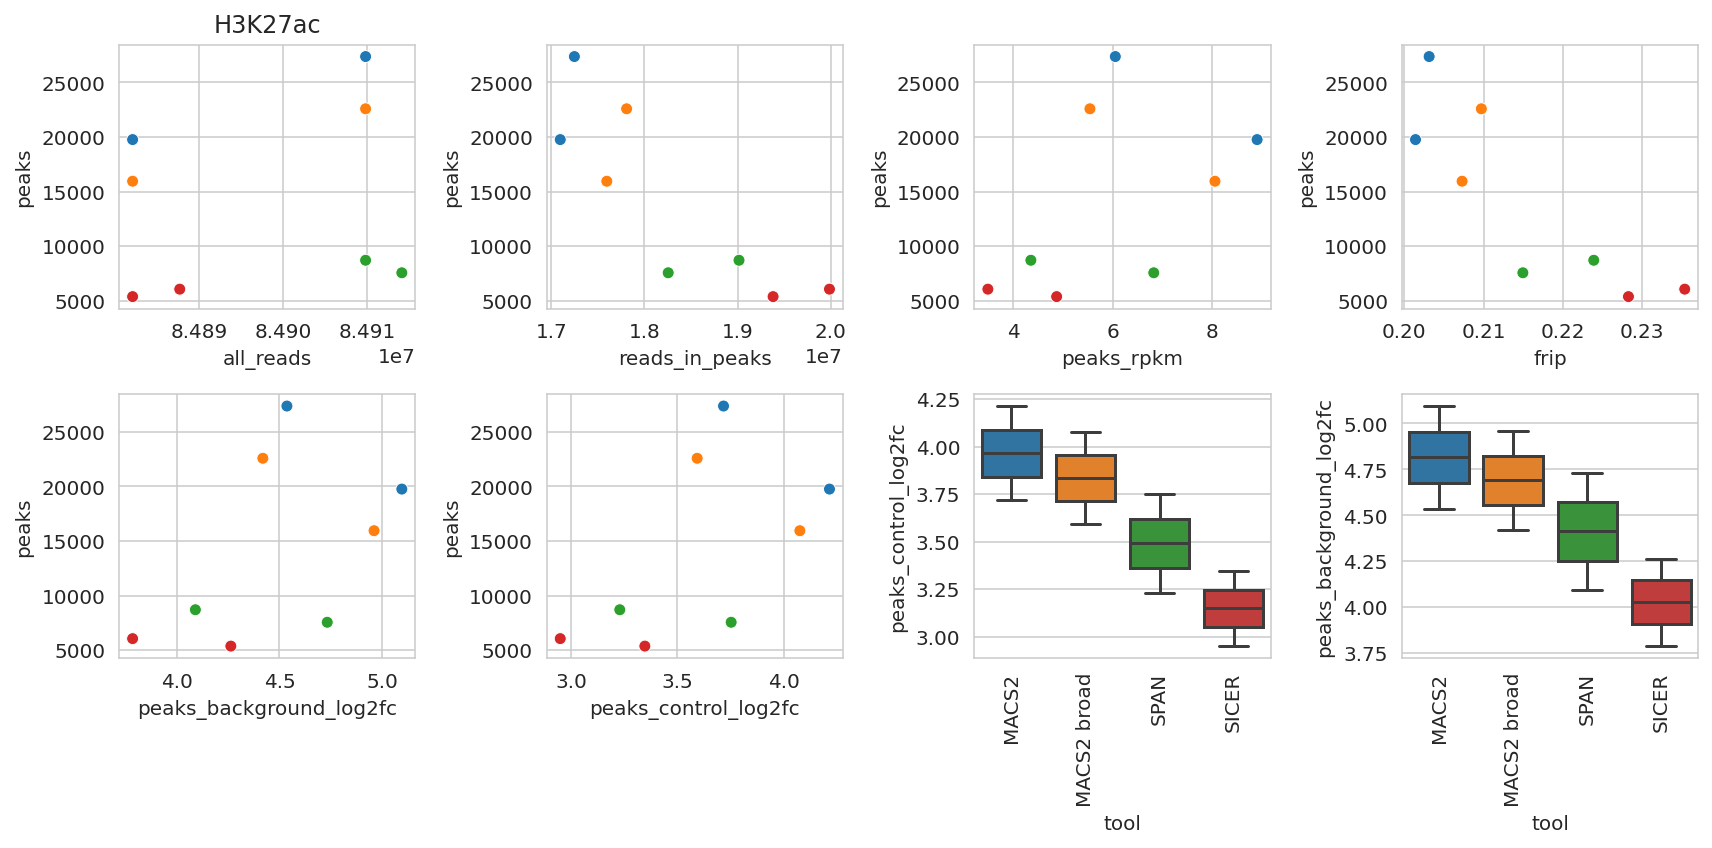

In [61]:
import seaborn as sns

t = frip_df
plt.figure(figsize=(12, 6))
axs = [plt.subplot(2, 4, i + 1) for i in range(8)]
ax = axs[0]
ax.set_title('H3K27ac')
g_results = sns.scatterplot(data=t, x='all_reads', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[1]
g_results = sns.scatterplot(data=t, x='reads_in_peaks', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[2]
g_results = sns.scatterplot(data=t, x='peaks_rpkm', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[3]
g_results = sns.scatterplot(data=t, x='frip', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[4]
g_results = sns.scatterplot(data=t, x='peaks_background_log2fc', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[5]
g_results = sns.scatterplot(data=t, x='peaks_control_log2fc', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[6]
g_results = sns.boxplot(data=t, x='tool', y='peaks_control_log2fc',
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        showfliers=False,
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)
# g_results.axes.legend().set_visible(False)


ax = axs[7]
g_results = sns.boxplot(data=t, x='tool', y='peaks_background_log2fc',
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        showfliers=False,
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)
# g_results.axes.legend().set_visible(False)
# Put a legend to the right of the current axis
# g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.show()

## Density Peaks

In [62]:
import pyBigWig
import tempfile
from itertools import product

tf = tempfile.mktemp()

coverage_data = []

for c in tqdm(IMMUNE_CELLS):
    print(c)
    t = bws_df[(bws_df['modification'] == 'H3K27ac') &
               (bws_df['cell'] == c)]
    if len(t) == 0:
        continue
    bw_file = t['file'].values[0]
    t = bws_control_df[bws_control_df['cell'] == c]
    if len(t) == 0:
        continue
    bw_control_file = t['file'].values[0]
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        if lines(peaks_file) > 0:
            t = pd.read_csv(peaks_file, sep='\t', header=None)
            positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            with pyBigWig.open(bw_file) as bw:
                total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K27ac', c, tool, pos, length, 'treatment', peak_coverage, total_coverage))
            with pyBigWig.open(bw_control_file) as bwc:
                total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2])]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K27ac', c, tool, pos, length, 'control', peak_coverage, total_coverage))
        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            if lines(tf) > 0:
                t = pd.read_csv(tf, sep='\t', header=None)
                positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                with pyBigWig.open(bw_file) as bw:
                    total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                    peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K27ac', c, name, pos, length, 'treatment', peak_coverage, total_coverage))
                with pyBigWig.open(bw_control_file) as bwc:
                    total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                    peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2])]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K27ac', c, name, pos, length, 'control', peak_coverage, total_coverage))

df_coverage = pd.DataFrame(
    coverage_data,
    columns=['modification', 'cell', 'name', 'position', 'length', 'type', 'coverage', 'total_coverage']
)
del coverage_data
df_coverage.sample(5)

  0%|          | 0/2 [00:00<?, ?it/s]

BCell
TCell


,modification,cell,name,position,length,type,coverage,total_coverage
196528,H3K27ac,TCell,MACS2 broad,chr2:134205684-134206187,503,treatment,91.993793,8.490978e+07
211504,H3K27ac,TCell,MACS2 broad,chr12:6468336-6469024,688,control,27.341169,8.485940e+07
161495,H3K27ac,TCell,SICER,chr1:193181200-193190199,8999,control,336.783207,8.482415e+07
225714,H3K27ac,TCell,MACS2 broad,chr6:37180017-37181926,1909,control,66.513184,8.485940e+07
202111,H3K27ac,TCell,MACS2 broad,chr5:139297879-139298293,414,treatment,55.380351,8.490978e+07


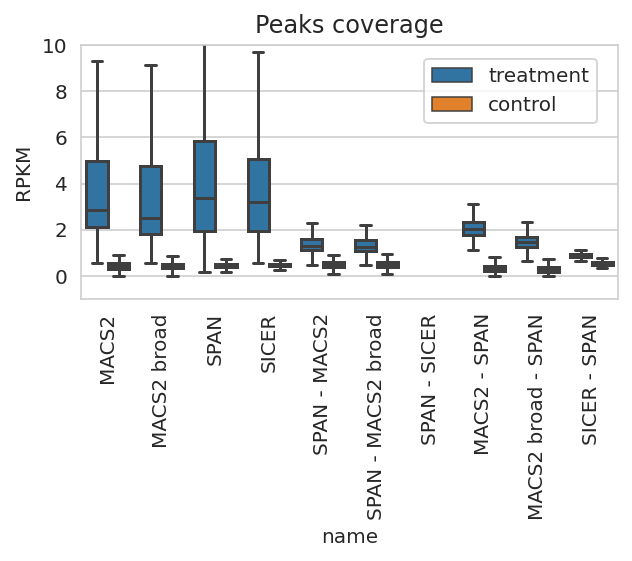

In [63]:
df_coverage['rpm'] = df_coverage['coverage'] / (df_coverage['total_coverage'] / 1e6)
df_coverage['rpkm'] = df_coverage['rpm'] / (df_coverage['length'] / 1e3)

plt.figure(figsize=(4.5, 4))
g_results = sns.boxplot(data=df_coverage, x='name', y='rpkm', hue='type',
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ],
                        showfliers=False)
ax = g_results.axes
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('RPKM')
ax.set_ylim(-1, 10)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(0.62, 0.82))
plt.title('Peaks coverage')
plt.tight_layout()
plt.show()